# 1. Business Understanding

## Stakeholder & Problem
**Primary Stakeholder:** Sarah Chen, Senior Product Manager for iOS at Apple Inc.

Sarah's team currently spends significant manual effort monitoring Twitter sentiment about iOS releases and features. This process is slow, inconsistent, and doesn't scale to handle the thousands of daily Apple-related tweets.

## Business Objective
**Primary Objective**
Develop an automated sentiment classification system that can process Twitter data in real-time to provide actionable insights about Apple product sentiment.

**Technical Objectives**
- Build a Multi-Class Classification Model that accurately categorizes tweets as Positive, Negative, or Neutral

- Achieve >80% Accuracy on sentiment classification to ensure reliable business insights

- Implement Model Interpretability to identify key words and phrases driving sentiment predictions

- Create a Preprocessing Pipeline that can handle real-world Twitter data with noise, emojis, and informal language

- Establish a Validation Framework to ensure model performance generalizes to unseen data

### **Success Metrics**
- **Technical:** >80% accuracy on test set, interpretable feature importance
- **Business:** Actionable insights for product team, clear path to deployment
- **Stakeholder:** Model that addresses specific pain points with measurable benefits

# Data Understanding

## Data Source & Description
- **Dataset:** Twitter Sentiment Analysis (Apple vs. Google) from CrowdFlower via data.world
- **Collection Method:** Human raters manually labeled tweet sentiment
- **Size:** 9,093 tweets
- **Time Period:** Historical tweets about Apple and Google products

## Data Exploration & Analysis

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Load the dataset
df = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding='ISO-8859-1')

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (9093, 3)


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


- Our dataset contains **9,093 tweets** across **3 columns**
- This provides a substantial amount of data for building a robust sentiment analysis model

**Column Overview:**
1. **tweet_text**: The actual content of the tweet (our primary feature)
2. **emotion_in_tweet_is_directed_at**: The brand/product being mentioned (Apple, Google, etc.)
3. **is_there_an_emotion_directed_at_a_brand_or_product**: The sentiment label (Positive/Negative/Neutral emotion)

**Initial Observations:**
- The tweets appear to mention various tech brands (iPhone, iPad, Google)
- Sentiment labels are already provided, making this a supervised learning problem
- We can see examples of both positive and negative emotions in the sample

In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


- We have 9,093 total tweets in our dataset
- There are 3 columns
- The dataset uses about 213 KB of memory

In [7]:
df.dtypes

tweet_text                                            object
emotion_in_tweet_is_directed_at                       object
is_there_an_emotion_directed_at_a_brand_or_product    object
dtype: object

- All the columns are of type object

In [9]:
df.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

**Tweet Text Column:**
- Only 1 missing value out of 9,093 tweets
- We can safely remove this single row without affecting our analysis

**Brand/Product Target Column:**
- 5,802 missing values, this is a high number
- But since we will be focusing on sentiment classification rather than brand tracking, we can still proceed with our analysis

**Sentiment Label Column:**
- zero missing values
- Every single tweet has a sentiment label (Positive, Negative, or Neutral)

In [11]:
# Check for completely duplicate rows in the dataset
df.duplicated().sum()

22

- Out of our 9,093 tweets22 duplicates
- This represents about 0.24% of our data which is a very small size but we will take it out later

### Conclusion

- Complete sentiment labels (0% missing in target variable)
- One missing tweet text and significant missing brand data, though this doesn't impact our core sentiment analysis goal
- 22 duplicate entries found that should be removed

### Target Variable Initial Analysis
- The target column is: `is_there_an_emotion_directed_at_a_brand_or_product`

In [13]:
# Analyze the distribution of sentiment labels in our dataset
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

1. **Severe Class Imbalance**: This is a major challenge for our model
   - Neutral tweets dominate the dataset (59%)
   - Negative sentiment is significantly underrepresented (only 6%)

2. **Data Quality Issue**: The "I can't tell" category (156 tweets) represents ambiguous labels that may need special handling

3. We now can either use:
   - **Binary Classification**: Focus only on Positive vs Negative emotions (dropping neutral/ambiguous tweets)
   - **Multi-class Classification**: Handle all four categories with imbalance mitigation techniques

#### Visualizing Sentiment Distribution

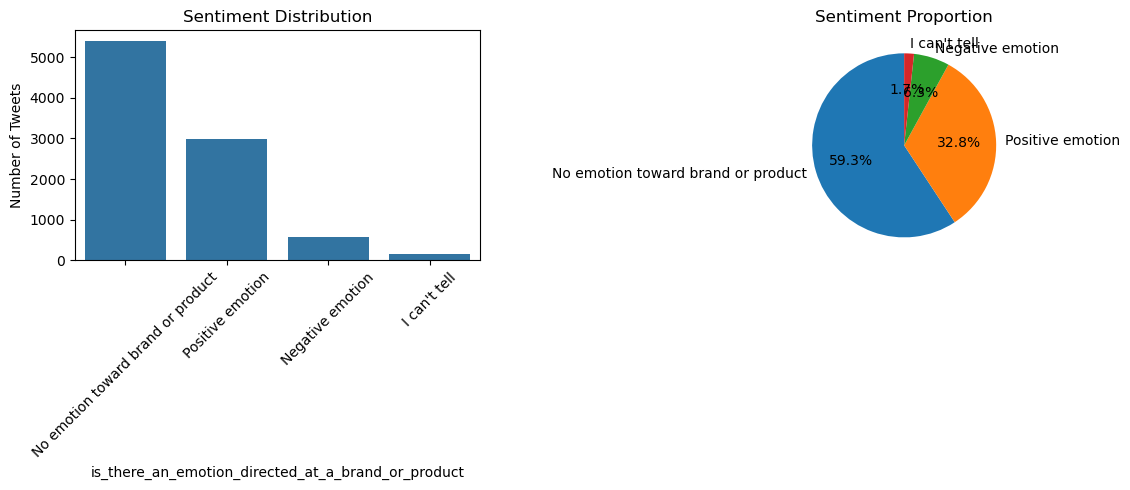

In [15]:
sentiment_counts = df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

# Visualize sentiment distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Sentiment Distribution')
plt.xticks(rotation=45)
plt.ylabel('Number of Tweets')

plt.subplot(1, 2, 2)
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Sentiment Proportion')

plt.tight_layout()
plt.show()

**Insights:**

1. **Dominance of Neutral Sentiment**: `No emotion toward brand or product` accounts for nearly 60% of all tweets, forming the majority class.

2. **Significant Class Imbalance**: 
   - Positive sentiment represents about one-third of the data (32.8%)
   - Negative sentiment is severely underrepresented at only 6.3%
   - The "I can't tell" category is minimal at 1.7%

3. **Business Implications**: 
   - The imbalance suggests we need careful model evaluation beyond simple accuracy
   - Metrics like precision, recall, and F1-score will be crucial, especially for the minority negative class
   - We may need techniques like class weighting or oversampling to handle the imbalance

**Next Steps**: Given this distribution, we'll likely proceed with binary classification (Positive vs Negative) by filtering out neutral and ambiguous tweets for our initial model.

### BRAND MENTION ANALYSIS
- Analyzing which brands are mentioned in the dataset

In [44]:
df['emotion_in_tweet_is_directed_at'].value_counts()

emotion_in_tweet_is_directed_at
iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: count, dtype: int64

**Key Observations:**

1. **Apple Dominance**: Apple products (iPad, iPhone, Apple brand) account for the majority of mentions in the dataset
2. **Product Focus**: Specific hardware products (iPad, iPhone) are discussed more frequently than general brand names(apple)

**Note:** Remember that 64% of tweets don't have brand information, so these numbers only represent the tweets where the target brand was specified.

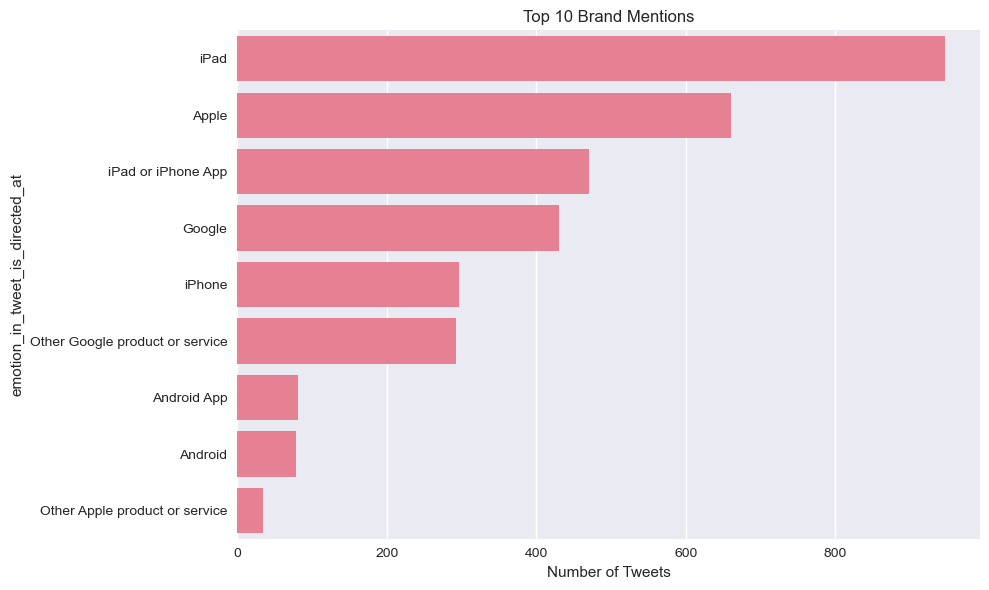

In [48]:
brand_counts = df['emotion_in_tweet_is_directed_at'].value_counts()

# Visualize brand mentions
plt.figure(figsize=(10, 6))
brand_counts_plot = brand_counts.head(10)  # Top 10 brands
sns.barplot(x=brand_counts_plot.values, y=brand_counts_plot.index)
plt.title('Top 10 Brand Mentions')
plt.xlabel('Number of Tweets')
plt.tight_layout()
plt.show()

**Insights:**

1. **Apple Product Dominance**: iPad leads as the most discussed product, followed by general Apple brand mentions and iPad/iPhone apps

2. **Competitive Presence**: Google maintains a strong presence with 430 mentions.

3. **Product vs Brand**: Specific products (iPad, iPhone) generate more discussion than general brand names, suggesting consumers tweet about specific experiences with hardware and apps

4. The presence of both iOS and Android platforms indicates cross-platform comparisons and discussions

**Strategic Implications for Apple Product Manager:**
- iPad-related conversations are the most frequent, making this a key area for sentiment monitoring
- App store sentiment (both iPad and iPhone apps) represents a significant portion of user feedback

## Test Data Characteristics Analysis

In [23]:
# Calculate text statistics
df['tweet_length'] = df['tweet_text'].str.len()
df['tweet_length'].describe()

count    9092.000000
mean      104.962275
std        27.187640
min        11.000000
25%        86.000000
50%       109.000000
75%       126.000000
max       178.000000
Name: tweet_length, dtype: float64

**Analysis:**

**Key Statistics:**
- **Average tweet length**: 105 characters
- **Shortest tweet**: 11 characters 
- **Longest tweet**: 178 characters 
- **Middle 50% of tweets**: Between 86 and 126 characters
- **Standard deviation**: 27 characters

**Interpretation:**

1. Most tweets fall in the 86-126 character range, which is quite significant for sentiment analysis
2. The average length suggests most tweets contain meaningful content rather than just brief mentions
3. **Modeling Considerations**: 
   - Sufficient text length for our models to learn patterns
   - Not too long to cause computational inefficiency
   - Standard deviation of 27 shows consistent tweet lengths across the dataset

**Note** The tweet lengths are well-distributed and of sufficient length to contain meaningful sentiment signals, which should help our classification models perform well.

In [38]:
# Text statistics by sentiment

text_stats_by_sentiment = df.groupby('is_there_an_emotion_directed_at_a_brand_or_product').agg({'tweet_length': ['mean', 'std']}).round(2)
text_stats_by_sentiment

tweet_length       
                                                           mean    std
is_there_an_emotion_directed_at_a_brand_or_product                    
I can't tell                                             103.98  27.91
Negative emotion                                         109.45  27.39
No emotion toward brand or product                       104.19  27.13
Positive emotion                                         105.56  27.13

**Key Insights:**

- Negative tweets tend to be longer

- Positive tweets are moderate in length

- Ambiguous tweets are shortest

- The standard deviation is similar across all categories (27 characters), showing consistent length variability regardless of sentiment.

**Business Implication**: The fact that negative tweets are longer could be valuable for customer service 
- users might be providing more detailed feedback when they're unhappy.

**Note**: The differences being subtle suggests that tweet length could be a minor feature in our sentiment classification model.

### Visualising Text Characteristics By Sentiment

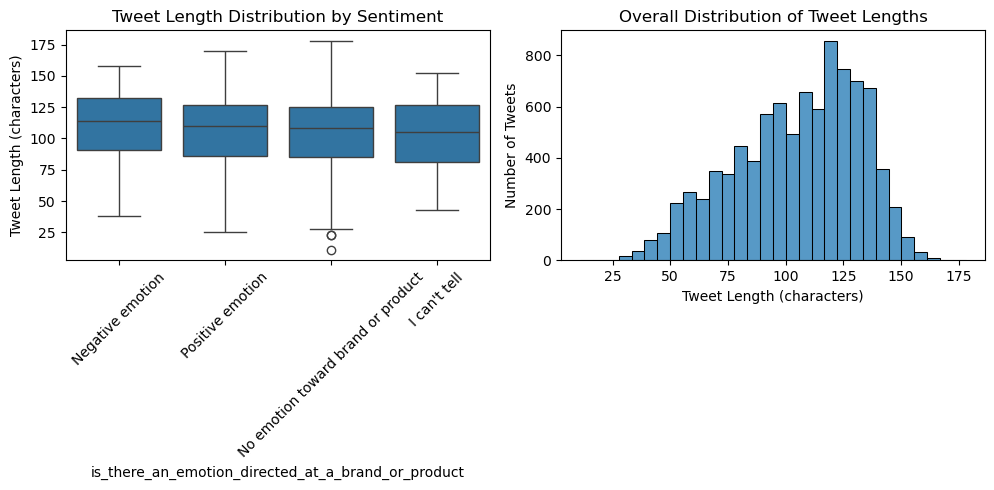

In [46]:
# Create visualizations for tweet length analysis
plt.figure(figsize=(15, 5))

# Box plot: Tweet length distribution by sentiment category
plt.subplot(1, 3, 1)
sns.boxplot(data=df, x=target_col, y='tweet_length')
plt.title('Tweet Length Distribution by Sentiment')
plt.xticks(rotation=45)
plt.ylabel('Tweet Length (characters)')

# Histogram: Overall distribution of tweet lengths
plt.subplot(1, 3, 2)
sns.histplot(data=df, x='tweet_length', bins=30)
plt.title('Overall Distribution of Tweet Lengths')
plt.xlabel('Tweet Length (characters)')
plt.ylabel('Number of Tweets')

plt.tight_layout()
plt.show()

**Insights:**

**Box Plot Observations:**
- Negative emotion tweets show slightly higher median length, confirming our earlier finding
  
**Histogram Observations:**
- Tweet lengths follow a roughly normal distribution with a peak around 115-130 characters
- The distribution is slightly right-skewed, with more very short tweets than very long ones


## Sample Tweet Analysis by Sentiment

In [57]:
def display_sample_tweets(sentiment_type, n_samples=4):
    samples = df[df[target_col] == sentiment_type]['tweet_text'].dropna().head(n_samples)
    print(f"\n--- {sentiment_type.upper()} TWEETS (Sample) ---")
    for i, tweet in enumerate(samples, 1):
        print(f"{i}. {tweet}")
        print(f"   Length: {len(tweet)} chars, Words: {len(tweet.split())}")
        print()

# Display samples for each sentiment
for sentiment in df[target_col].unique():
    display_sample_tweets(sentiment)


--- NEGATIVE EMOTION TWEETS (Sample) ---
1. .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.
   Length: 127 chars, Words: 23

2. @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw
   Length: 82 chars, Words: 15

3. I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone
   Length: 128 chars, Words: 24

4. @mention  - False Alarm: Google Circles Not Coming NowÛÒand Probably Not Ever? - {link} #Google #Circles #Social #SXSW
   Length: 119 chars, Words: 18


--- POSITIVE EMOTION TWEETS (Sample) ---
1. @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW
   Length: 139 chars, Words: 22

2. @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.
   Length: 79 chars, Words: 15

3. @sxtxstate great st

### Negative Emotion Tweets (Sample)

**Patterns Observed:**
- **Complaints about functionality**: Battery life, app crashes, technical issues
- **Frustration expression**: Words like "dead", "crashy", "hope... isn't"
- **Problem-focused**: Specific issues with products during events like SXSW

**Key Characteristics:**
- Focus on product failures and inconveniences
- Often mention specific events or contexts
- Use of exclamation points and negative framing

### Positive Emotion Tweets (Sample)

**Patterns Observed:**
- **Praise for design and features**: "Awesome", "great stuff", "appreciate"
- **Excitement and anticipation**: "Can not wait", "likely appreciate"
- **Recommendations**: Suggesting apps to others
- **Event enthusiasm**: Positive experiences at SXSW conference

**Key Characteristics:**
- Complimentary language and enthusiasm
- Focus on aesthetics and user experience
- Sharing positive discoveries with others

### No Emotion Toward Brand Tweets (Sample)

**Patterns Observed:**
- **Informational/neutral**: Factual announcements, links, event information
- **Promotional content**: App store links, conference showcases
- **Objective reporting**: Straightforward information without emotional language
- **Hashtag-heavy**: Often include multiple topic tags

**Key Characteristics:**
- Neutral, factual language
- Lack of emotional words or judgment
- Focus on sharing information rather than expressing opinion

### I Can't Tell Tweets (Sample)

**Patterns Observed:**
- **Ambiguous context**: Mixed signals or unclear references
- **Indirect mentions**: Brands mentioned in passing or third-party contexts
- **Sarcasm potential**: Some tweets might contain subtle sarcasm
- **News sharing**: Reporting news without clear personal stance

**Key Characteristics:**
- Context-dependent sentiment
- Potential for misinterpretation
- Often require deeper understanding of references

## Brand and Sentiment Cross-Analysis

<Figure size 1200x600 with 0 Axes>

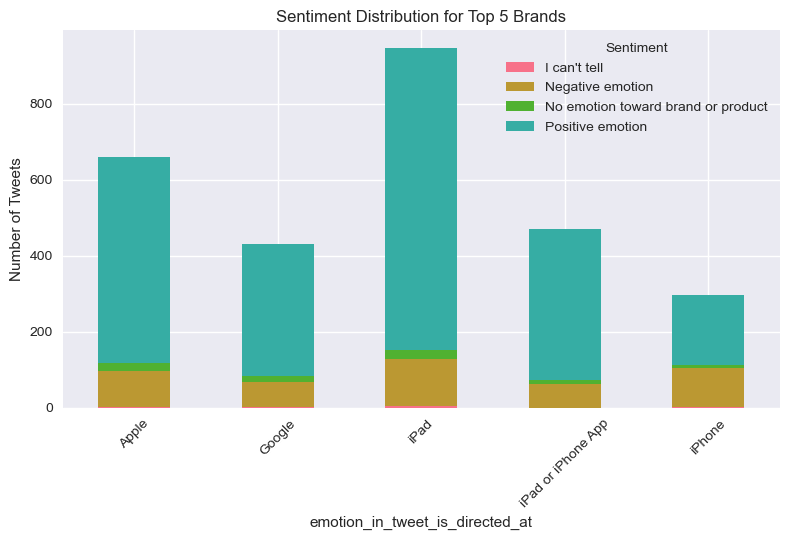

In [101]:
# Analyze relationship between brand mentions and sentiment
if df[brand_col].notnull().sum() > 0:
    brand_sentiment = pd.crosstab(df[brand_col], df[target_col], margins=True)
    
    # Visualize for top brands
    top_brands = brand_counts.index[:5]  # Top 5 brands
    brand_sentiment_top = pd.crosstab(
        df[df[brand_col].isin(top_brands)][brand_col], 
        df[df[brand_col].isin(top_brands)][target_col]
    )
    
    plt.figure(figsize=(12, 6))
    brand_sentiment_top.plot(kind='bar', stacked=True)
    plt.title('Sentiment Distribution for Top 5 Brands')
    plt.xticks(rotation=45)
    plt.ylabel('Number of Tweets')
    plt.legend(title='Sentiment')
    plt.tight_layout()
    plt.show()

# Data Cleaning

## Removing duplicates and empty tweets

In [112]:
# Removing duplicates
df = df.drop_duplicates(subset=['tweet_text'])
df.shape[0]

9066

In [114]:
# Removing tweets with missing text
df = df.dropna(subset=['tweet_text'])
df.shape[0]

9065

In [120]:
# Removing very short tweets (2 words or less)
df = df[df['tweet_text'].str.split().str.len() > 2]
df.shape[0]

9064

## Maping sentiment labels

In [123]:
# Creating simpler sentiment categories
sentiment_map = {
    'No emotion toward brand or product': 'Neutral',
    'Positive emotion': 'Positive', 
    'Negative emotion': 'Negative',
    "I can't tell": 'Neutral'
}

df['sentiment'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].map(sentiment_map)

In [125]:
df['sentiment'].value_counts()

sentiment
Neutral     5527
Positive    2968
Negative     569
Name: count, dtype: int64

## Basic text cleaning

In [138]:

import re

def clean_tweet(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    # Removing URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    # Removing mentions
    text = re.sub(r'@\w+', '', text) 
    # Normalizing whitespace
    text = re.sub(r'\s+', ' ', text)                 
    return text.strip()


df['cleaned_text'] = df['tweet_text'].apply(clean_tweet)

# Showing examples
for i in range(3):
    print(f"Before: {df['tweet_text'].iloc[i][:80]}...")
    print(f"After:  {df['cleaned_text'].iloc[i][:80]}...")
    print()

Before: .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead...
After:  . i have a 3g iphone. after 3 hrs tweeting at #rise_austin, it was dead! i need ...

Before: @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appre...
After:  know about ? awesome ipad/iphone app that you'll likely appreciate for its desig...

Before: @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW....
After:  can not wait for #ipad 2 also. they should sale them down at #sxsw....



In [142]:
# Checking cleaned data

print(f"Total tweets: {len(df)}")

print(df['sentiment'].value_counts())



Total tweets: 9064
sentiment
Neutral     5527
Positive    2968
Negative     569
Name: count, dtype: int64


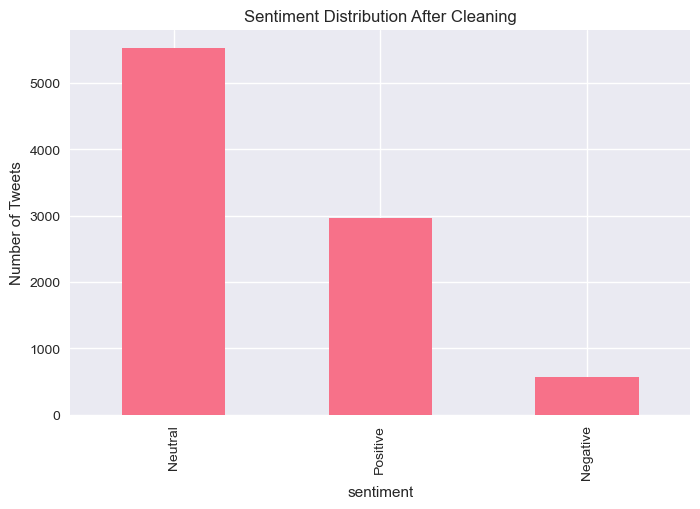

In [140]:
# Ploting new distribution
plt.figure(figsize=(8, 5))
df['sentiment'].value_counts().plot(kind='bar')
plt.title('Sentiment Distribution After Cleaning')
plt.ylabel('Number of Tweets')
plt.show()

### selecting the needed columns

In [145]:
final_df = df[['cleaned_text', 'sentiment']].copy()
final_df.head()

,cleaned_text,sentiment
0,. i have a 3g iphone. after 3 hrs tweeting at ...,Negative
1,know about ? awesome ipad/iphone app that you'...,Positive
2,can not wait for #ipad 2 also. they should sal...,Positive
3,i hope this year's festival isn't as crashy as...,Negative
4,great stuff on fri #sxsw: marissa mayer (googl...,Positive


In [147]:
final_df.columns

Index(['cleaned_text', 'sentiment'], dtype='object')

In [149]:
final_df.shape

(9064, 2)